In [46]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.io as io
import matplotlib.pylab as plt
from pathlib import Path

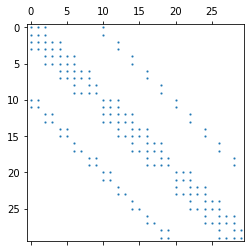

In [47]:
path = "/home/vatai/Downloads/ch3-3-b2/"
path = "/home/vatai/Downloads/farm/"
path = "/home/vatai/Downloads/mesh1em1/"
path = "/home/vatai/Downloads/b1_ss/"
path = "/home/vatai/Downloads/pores_1/"
files = list(Path(path).glob("*"))

fig, axs = plt.subplots(nrows=1, ncols=len(files))

for i, file in enumerate(files):
    A = io.mmread(file)
    ax = axs[i] if len(files) > 1 else axs
    ax.spy(A, markersize=1)


In [54]:
b = np.ones((A.shape[0], 1))
sol = linalg.spsolve(A, b)
np.linalg.norm(A @ sol - b)

/usr/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


2.8905572596485424e-10

In [56]:
def cg(A, b):
    pass

cg_sol = cg(A, b)

def s_step_cg(A, b):
    pass

s_sol = s_step_cg(A, b)